<a href="https://colab.research.google.com/github/sanadelph/pcg_binary_classification/blob/main/pcg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os
import sys
!{sys.executable} -m pip install deap
!{sys.executable} -m pip install bitstring
!{sys.executable} -m pip install python_speech_features

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from random import shuffle
import math
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Input, Dense, Bidirectional, Dropout
from keras.models import Model, Sequential
from deap import base, creator, tools, algorithms
from bitstring import BitArray
from scipy.io import wavfile
import scipy.signal
from scipy.stats import bernoulli
from sklearn.preprocessing import StandardScaler
import IPython
from python_speech_features import mfcc
import librosa
import matplotlib.pyplot as plt


drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=5b829b746760d389370c190c5c7002e19aa6be86a9d25d3881782a3db4e61eaa
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Mounted at /content/drive


In [27]:
def load_data(folder, trainingFolders):
  waves=[]
  audioDataset=[]
  for tf in trainingFolders:
    dataset = pd.read_csv('/content/drive/MyDrive/{}/{}/REFERENCE.csv'.format(folder,tf), header=None, names =['filename', 'target'])
    waves.append(dataset)

  wav=pd.concat(waves)
  wav.target.replace(to_replace=-1, value=0, inplace=True) #replacing -1 lable of Normal wave to 0
  print(wav)

  for tf in trainingFolders:
      for filename,target in zip(wav.filename,wav.target):
          path_wav = "/content/drive/MyDrive/{}/{}/{}.wav".format(folder,tf,filename)
          if os.path.exists(path_wav):
            sampFreq, audio = wavfile.read(path_wav)            # Return the sample rate (in samples/sec) and data from a WAV file
            label=target
            audioDataset.append({"audio":audio,"label": label,"samplingRate":sampFreq})
  return audioDataset

audioDataset=load_data('training',['training-a','training-b','training-c','training-d','training-e','training-f'])

    filename  target
0      a0001       1
1      a0002       1
2      a0003       1
3      a0004       1
4      a0005       1
..       ...     ...
109    f0110       0
110    f0111       0
111    f0112       0
112    f0113       0
113    f0114       0

[3240 rows x 2 columns]
3240


Abnormal PCG Signal


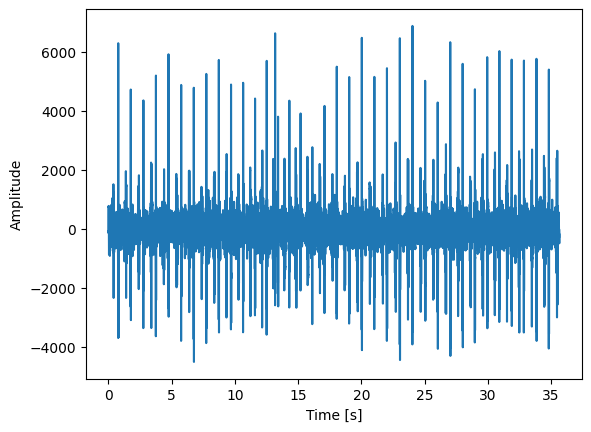



Normal PCG Signal


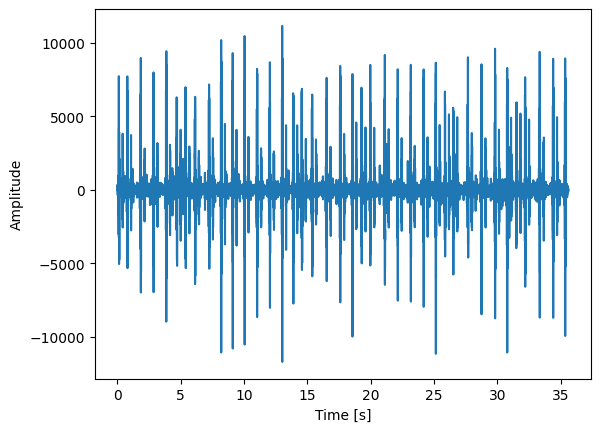

In [4]:
print("Abnormal PCG Signal")
abnormal= audioDataset[0]
length = abnormal['audio'].shape[0] / abnormal['samplingRate']
time = np.linspace(0., length, abnormal['audio'].shape[0])
plt.plot(time, abnormal['audio'])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

print("\n\nNormal PCG Signal")
normal= audioDataset[10]
length = normal['audio'].shape[0] / normal['samplingRate']
time = np.linspace(0., length, normal['audio'].shape[0])
plt.plot(time, normal['audio'])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

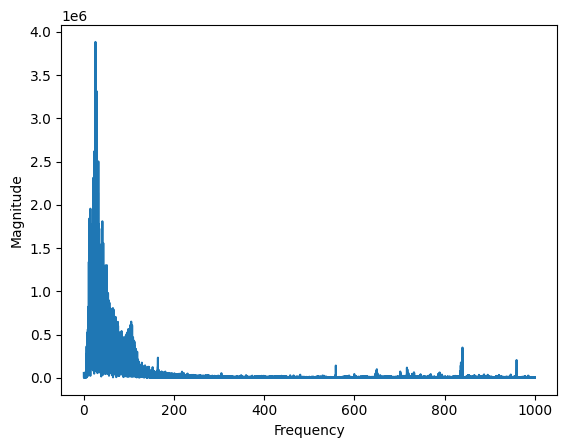

In [5]:
fft=np.fft.fft(audioDataset[0]['audio'])
spectrum=np.abs(fft)
frequency = np.linspace(0, audioDataset[0]['samplingRate'], len(spectrum))

left_spectrum=spectrum[:int(len(frequency)/2)]
left_frequency=frequency[:int(len(frequency)/2)]
plt.plot(left_frequency, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()



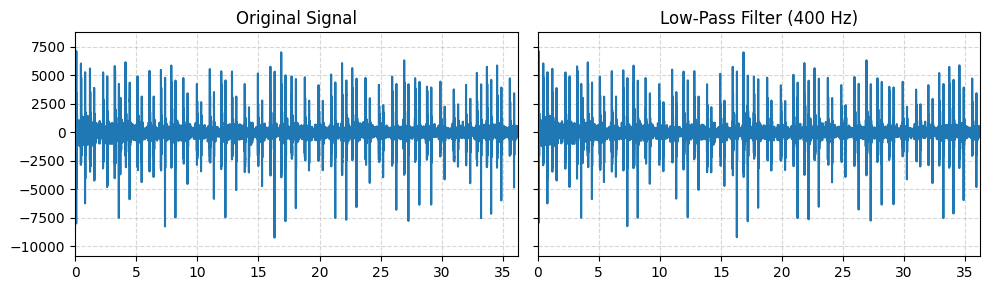

In [29]:
filteredSignals=[]
times=[]
order=5
cutoff=400
for audio in audioDataset:
  times.append(np.arange(len(audio['audio']))/audio['samplingRate'])
  sos = scipy.signal.butter(order, cutoff, 'lowpass', fs=audio['samplingRate'], output='sos')
  filteredSignals.append(scipy.signal.sosfiltfilt(sos, audio['audio']))

# Apply a 400 Hz low-pass filter to the original data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
ax1.plot(times[400], audioDataset[400]['audio'])
ax1.set_title("Original Signal")
ax1.margins(0, .1)
ax1.grid(alpha=.5, ls='--')
ax2.plot(times[400], filteredSignals[400])
ax2.set_title("Low-Pass Filter (400 Hz)")
ax2.grid(alpha=.5, ls='--')
plt.tight_layout()
plt.show()


In [31]:
mfcc_features = list()
labels = []
max_sequence_length = 500
num_mfcc=13

for i,audio in enumerate(audioDataset):
  MFCCs = mfcc(filteredSignals[i],
               audio['samplingRate'],
               nfft=1024,
               numcep=num_mfcc)
  if MFCCs.shape[0] < max_sequence_length:
    pad_width = max_sequence_length - MFCCs.shape[0]
    temp = np.pad(MFCCs, pad_width=((0, pad_width),(0, 0)))
  else:
    temp = MFCCs[:max_sequence_length,:]
  mfcc_features.append({"label": audio['label'], "mfcc": temp})

mfcc_features = np.array(mfcc_features)
# print(mfcc_features[500]['mfcc'])
# print(len(mfcc_features))
# print(mfcc_features[209]['mfcc'].shape)


[[ 13.57676514  16.10998819   9.51639432 ...  -4.98036065 -10.13021757
  -11.71874626]
 [ 15.16457847  19.74981191  16.39111408 ...   9.96314397   5.70348599
    0.20103651]
 [ 15.40602389  27.15491395  20.5898181  ...  -0.9036393    0.53341452
    4.37199373]
 ...
 [ 12.99606754  20.04188675  14.63121001 ...   1.06739848   4.22847451
    3.40926385]
 [ 13.79643102  23.25351747  16.69778111 ...   5.76041928   6.01071261
    8.36831311]
 [ 14.34243366  19.34277188  13.36760426 ...   4.61576394   4.15522573
    7.80604175]]
3240
(500, 13)


In [37]:
shuffle(mfcc_features)
train_files = list()
size = (8*len(mfcc_features))/10
train_features = mfcc_features[0:int(size)]
test_features = mfcc_features[int(size):]
train_size = 0
for feature in train_features:
    train_files.append({'label': feature["label"], 'feature': feature["mfcc"] })
    train_size += 1
x_train = np.zeros((train_size, max_sequence_length ,13))
y_train = np.zeros((train_size))
i = 0
for train_file in train_files:
    x_train[i,:,:] = train_file['feature']
    y_train[i] = train_file['label']
    i += 1

test_files = list()
test_size = 0
for feature in test_features:
  test_files.append({'label': feature["label"], 'feature': feature["mfcc"] })
  test_size += 1
x_test = np.zeros((test_size, max_sequence_length ,13))
y_test = np.zeros((test_size))
i = 0
for test_file in test_files:
    x_test[i,:,:] = test_file['feature']
    y_test[i] = test_file['label']
    i += 1


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(2592, 500, 13)
(2592,)
(648, 500, 13)
(648,)


In [33]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
print(x_train_scaled.shape)
print(x_test_scaled.shape)

(2592, 500, 13)
(648, 500, 13)


In [34]:
# def baseline_classifier(x_train,y_train,x_test,y_test):
#   stratified_classifier = DummyClassifier(strategy='stratified', random_state=42)
#   stratified_classifier.fit(x_train, y_train)
#   y_pred = stratified_classifier.predict(x_test)
#   accuracy = accuracy_score(y_test, y_pred)
#   return accuracy



def train_evaluate(ga_individual_solution):
    # Decode GA solution to integer for num_neurons, epochs
    num_neurons1_bits = BitArray(ga_individual_solution[:7])
    num_neurons2_bits = BitArray(ga_individual_solution[7:14])
    epoch_bits = BitArray(ga_individual_solution[14:])

    num_neurons1 = num_neurons1_bits.uint
    num_neurons2 = num_neurons2_bits.uint
    epoch = epoch_bits.uint


    print('\nNum of neurons1: ', num_neurons1,'\nNum of neurons2',num_neurons2, '\nEpoch:', epoch)

    # Return fitness score of 0 if num_neurons1 < 0 or num_neurons2 < 0 or epoch < 10
    if num_neurons1 <= 0 or num_neurons2 <= 0 or epoch < 10:
      return 0,

    #split into train and validation (80/20)
    X_train,X_test,Y_train,Y_test=train_test_split(x_train_scaled,y_train,test_size=0.2)

    model = Sequential()
    model.add(LSTM(units=num_neurons1, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=num_neurons2))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
    model.summary()

    history=model.fit(X_train, Y_train, epochs=epoch, verbose=0)
    # Y_pred = model.predict(X_test)
    val_accuracy=model.evaluate(x=X_test,y=Y_test)[1]
    print(f"Validation accuracy: ", val_accuracy)


    return val_accuracy,




population_size = 8
num_generations = 4
gene_length = 19
# As we are trying to minimize the RMSE score, that's why using -1.0.
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


best_individual = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None

for bi in best_individual:
  num_neurons1_bits = BitArray(bi[0:7])
  num_neurons2_bits = BitArray(bi[7:14])
  epoch_bits = BitArray(bi[14:])

  best_num_neurons1 = num_neurons1_bits.uint
  best_num_neurons2 = num_neurons2_bits.uint
  best_epoch = epoch_bits.uint

print('\nBest Num of neurons1: ', best_num_neurons1, '\nBest Num of neurons2: ',
        best_num_neurons2,'\nBest Epoch:', best_epoch)


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Num of neurons1:  79 
Num of neurons2 65 
Epoch: 2

Num of neurons1:  118 
Num of neurons2 100 
Epoch: 25
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 500, 118)          62304     
                                                                 
 dropout_58 (Dropout)        (None, 500, 118)          0         
                                                                 
 lstm_59 (LSTM)              (None, 100)               87600     
                                                                 
 dropout_59 (Dropout)        (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 150005 (585.96 KB)
Trainable params: 150005 (585.96 KB)
Non-trai

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 500, 22)           3168      
                                                                 
 dropout_86 (Dropout)        (None, 500, 22)           0         
                                                                 
 lstm_87 (LSTM)              (None, 72)                27360     
                                                                 
 dropout_87 (Dropout)        (None, 72)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 73        
                                                                 
Total params: 30601 (119.54 KB)
Trainable params: 30601 (119.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/22
57/5

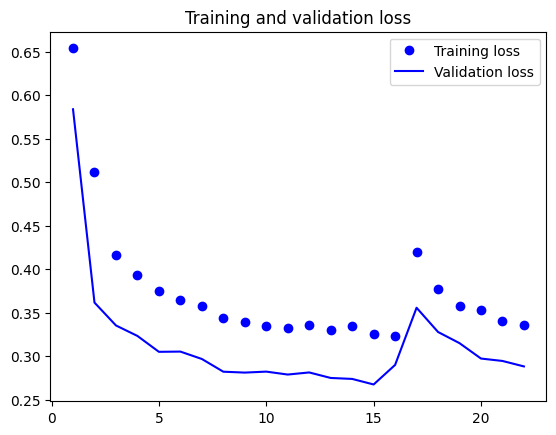

21/21 [==============================] - 3s 126ms/step - loss: 0.3014 - accuracy: 0.8657
GA Optimized Model Test Accuracy: 86.57


In [35]:
# from sklearn.metrics import accuracy_score
model = Sequential()
model.add(LSTM(units=best_num_neurons1, input_shape=(x_train_scaled.shape[1],x_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model.summary()

history=model.fit(x_train_scaled, y_train, validation_split = 0.3, epochs=best_epoch, batch_size=32)


import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


print(f"GA Optimized Model Test Accuracy: {model.evaluate(x=x_test_scaled,y=y_test)[1]*100:.2f}")
# print(f"Baseline Classifier Accuracy: {baseline_classifier(x_train,y_train,x_test,y_test)*100:.2f}")